In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score
import pickle

label_path = '../../data/S10000/symsim_labels_2000genes_10000cells_simple.csv'
dropout_levels = [round(i / 10, 1) for i in range(1, 10)]

#load constant labels
labels = pd.read_csv(label_path, index_col=0)
labels.index = labels.index.astype(int)

# To collect results
all_results = {}

for dropout in dropout_levels:
    print(f"\n=== Dropout Level: {dropout} ===")

    data_path = f"../../data/S10000/noise_dropout_{dropout}.csv"
    counts = pd.read_csv(data_path, index_col=0)
    #if counts.shape[0] > counts.shape[1]:
    counts = counts.T

    adata = sc.AnnData(counts)
    adata.obs.index = adata.obs.index.str.lstrip('X').astype(int)
    adata.obs['cell_class'] = labels.reindex(adata.obs.index)['x'].astype(str)

    metrics = {
        'euclidean': {},
        'manhattan': {},
        'minkowski_0.5': {}
    }

    for metric in metrics:
        trustworthiness_scores = []
        silhouette_scores = []

        for i in range(10):
            print(f"Metric: {metric}, Run: {i+1}/10")

            if metric == 'minkowski_0.5':
                sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='minkowski', metric_kwds={'p': 0.5})
            else:
                sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric=metric)

            sc.tl.umap(adata, random_state=None)

            # Trustworthiness
            tw = trustworthiness(adata.X, adata.obsm['X_umap'], n_neighbors=15)
            trustworthiness_scores.append(tw)

            # Silhouette Score
            sil_score = silhouette_score(adata.obsm['X_umap'], adata.obs['cell_class'])
            silhouette_scores.append(sil_score)

        metrics[metric] = {
            'trustworthiness': trustworthiness_scores,
            'silhouette': silhouette_scores,
            'trustworthiness_mean': np.mean(trustworthiness_scores),
            'trustworthiness_min': np.min(trustworthiness_scores),
            'trustworthiness_max': np.max(trustworthiness_scores),
            'silhouette_mean': np.mean(silhouette_scores),
            'silhouette_min': np.min(silhouette_scores),
            'silhouette_max': np.max(silhouette_scores)
        }

    all_results[f"dropout_{dropout}"] = metrics


# Save the all_results dictionary to a file
with open("all_results_S10000.pkl", "wb") as f:
    pickle.dump(all_results, f)

print("Saved all_results to all_results.pkl")
# Now all_results contains full score summaries for all dropout levels and distance metrics



=== Dropout Level: 0.1 ===
Metric: euclidean, Run: 1/10
Metric: euclidean, Run: 2/10
Metric: euclidean, Run: 3/10
Metric: euclidean, Run: 4/10
Metric: euclidean, Run: 5/10
Metric: euclidean, Run: 6/10
Metric: euclidean, Run: 7/10
Metric: euclidean, Run: 8/10
Metric: euclidean, Run: 9/10
Metric: euclidean, Run: 10/10
Metric: manhattan, Run: 1/10
Metric: manhattan, Run: 2/10
Metric: manhattan, Run: 3/10
Metric: manhattan, Run: 4/10
Metric: manhattan, Run: 5/10
Metric: manhattan, Run: 6/10
Metric: manhattan, Run: 7/10
Metric: manhattan, Run: 8/10
Metric: manhattan, Run: 9/10
Metric: manhattan, Run: 10/10
Metric: minkowski_0.5, Run: 1/10
Metric: minkowski_0.5, Run: 2/10
Metric: minkowski_0.5, Run: 3/10
Metric: minkowski_0.5, Run: 4/10
Metric: minkowski_0.5, Run: 5/10
Metric: minkowski_0.5, Run: 6/10
Metric: minkowski_0.5, Run: 7/10
Metric: minkowski_0.5, Run: 8/10
Metric: minkowski_0.5, Run: 9/10
Metric: minkowski_0.5, Run: 10/10

=== Dropout Level: 0.2 ===
Metric: euclidean, Run: 1/10
Me

In [3]:
print(all_results)

{'dropout_0.1': {'euclidean': {'trustworthiness': [0.9586606989408974, 0.9526597427416391, 0.956423927032174, 0.9521124352677826, 0.9602488303097123, 0.9525993017273061, 0.9523454311583308, 0.9602248277705389, 0.9524760449032775, 0.9519399719354515], 'silhouette': [0.29202822, 0.28787264, 0.3067734, 0.28515342, 0.30397823, 0.2832738, 0.28325367, 0.3013861, 0.2844073, 0.28270298], 'trustworthiness_mean': 0.954969121178711, 'trustworthiness_min': 0.9519399719354515, 'trustworthiness_max': 0.9602488303097123, 'silhouette_mean': 0.29108298, 'silhouette_min': 0.28270298, 'silhouette_max': 0.3067734}, 'manhattan': {'trustworthiness': [0.9554686151481742, 0.9553996091009321, 0.9556697176840065, 0.9551837659951221, 0.9552512512111189, 0.9557344519060506, 0.9553868330493468, 0.9558945808693328, 0.9556462363435902, 0.9554897617854399], 'silhouette': [0.75488997, 0.7455891, 0.7505353, 0.7072507, 0.7427767, 0.75612384, 0.70871514, 0.6906351, 0.74968916, 0.75469476], 'trustworthiness_mean': 0.95551

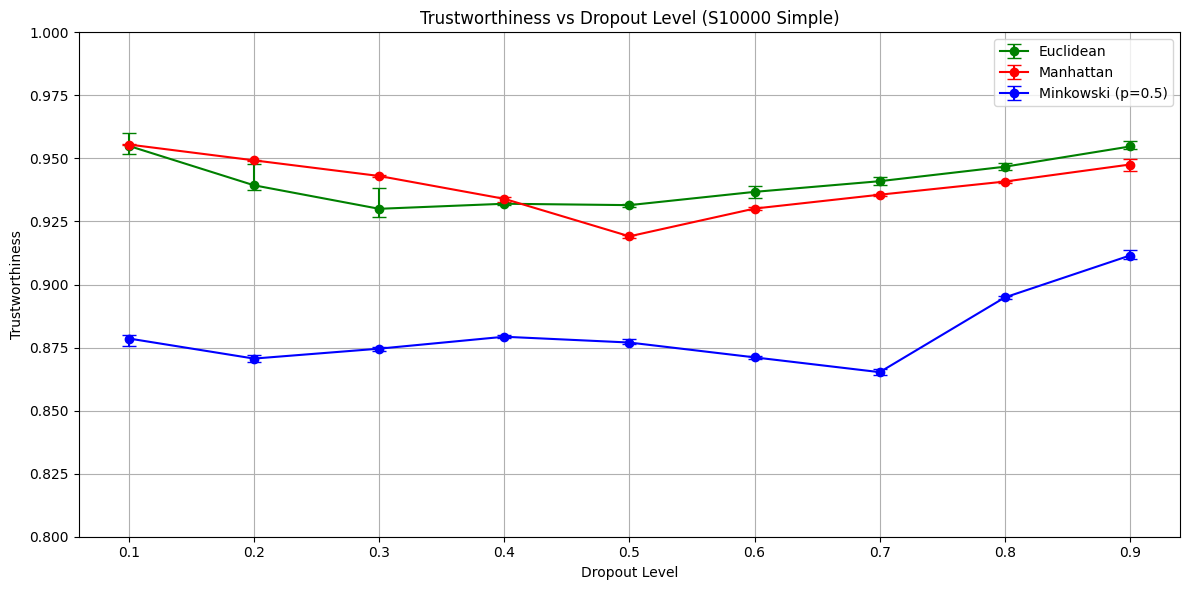

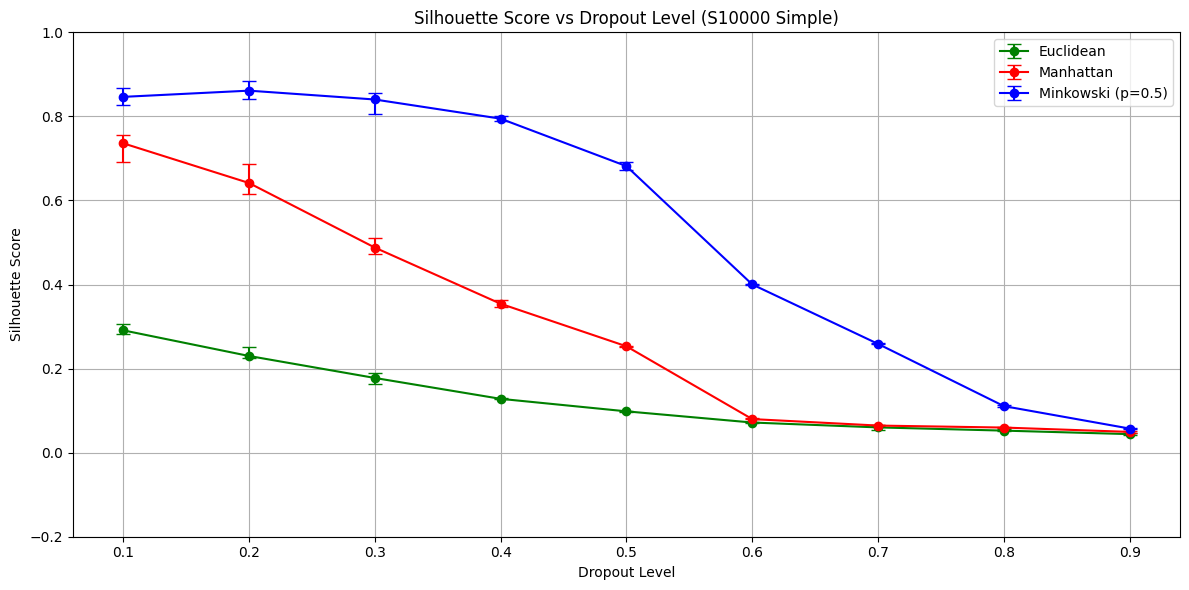

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dropout_levels = [round(i, 1) for i in np.arange(0.1, 1.0, 0.1)]
metrics_names = {
    'euclidean': 'Euclidean',
    'manhattan': 'Manhattan',
    'minkowski_0.5': 'Minkowski (p=0.5)'
}
colors = {
    'euclidean': 'green',
    'manhattan': 'red',
    'minkowski_0.5': 'blue'
}

# Try to generate the plots
if all_results:
    # Trustworthiness Plot
    plt.figure(figsize=(12, 6))
    for metric in metrics_names:
        trust_means = []
        trust_mins = []
        trust_maxs = []
        for d in dropout_levels:
            entry = all_results[f"dropout_{d}"][metric]
            trust_means.append(entry['trustworthiness_mean'])
            trust_mins.append(entry['trustworthiness_min'])
            trust_maxs.append(entry['trustworthiness_max'])
        trust_err_low = np.array(trust_means) - np.array(trust_mins)
        trust_err_high = np.array(trust_maxs) - np.array(trust_means)
        plt.errorbar(dropout_levels, trust_means, yerr=[trust_err_low, trust_err_high], label=metrics_names[metric], fmt='-o', capsize=5, color=colors[metric])
    plt.title('Trustworthiness vs Dropout Level (S10000 Simple)')
    plt.xlabel('Dropout Level')
    plt.ylabel('Trustworthiness')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Silhouette Plot
    plt.figure(figsize=(12, 6))
    for metric in metrics_names:
        sil_means = []
        sil_mins = []
        sil_maxs = []
        for d in dropout_levels:
            entry = all_results[f"dropout_{d}"][metric]
            sil_means.append(entry['silhouette_mean'])
            sil_mins.append(entry['silhouette_min'])
            sil_maxs.append(entry['silhouette_max'])
        sil_err_low = np.array(sil_means) - np.array(sil_mins)
        sil_err_high = np.array(sil_maxs) - np.array(sil_means)
        plt.errorbar(dropout_levels, sil_means, yerr=[sil_err_low, sil_err_high], label=metrics_names[metric], fmt='-o', capsize=5, color=colors[metric])
    plt.title('Silhouette Score vs Dropout Level (S10000 Simple)')
    plt.xlabel('Dropout Level')
    plt.ylabel('Silhouette Score')
    plt.ylim(-0.2, 1.0)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("`all_results` not found. Please re-run the metric calculations or reload the saved data.")
